In [4]:
import sys
sys.path.append("..") 

from file import get_model 

model_paths = [
    "/mnt/data/ner/huggingface/" + x for x in [
        # "model_0710", 
        # "model_1410",
        # "model_2110", 
        # "model_3010",
        "model_2511"
    ] 
] 
_ = [get_model(x, dst_path="../models") for x in model_paths]

receiving incremental file list
model_2511/
model_2511/config.json
          1,067 100%    1.02MB/s    0:00:00 (xfr#1, to-chk=6/8)
model_2511/model.safetensors
    532,312,468 100%  110.46MB/s    0:00:04 (xfr#2, to-chk=5/8)
model_2511/special_tokens_map.json
            695 100%    1.13kB/s    0:00:00 (xfr#3, to-chk=4/8)
model_2511/tokenizer.json
      1,395,122 100%    2.18MB/s    0:00:00 (xfr#4, to-chk=3/8)
model_2511/tokenizer_config.json
          1,429 100%    2.28kB/s    0:00:00 (xfr#5, to-chk=2/8)
model_2511/training_args.bin
          4,728 100%    7.56kB/s    0:00:00 (xfr#6, to-chk=1/8)
model_2511/vocab.txt
        411,336 100%  653.16kB/s    0:00:00 (xfr#7, to-chk=0/8)


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    DataCollatorForTokenClassification,
    AutoModelForTokenClassification,
)
from datasets import load_metric, Dataset

/mnt/data/src/ner/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/data/src/ner/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
import sys
sys.path.append("..")

from dataset import clean_data, get_conll_dataset, conlldf2text, conlltext2df
from file import read_df
from fine_tune.constants import *

## Dataset

In [5]:
test_raw_data = read_df(VAL_DATASET)
test_cleaned_data = clean_data(test_raw_data, label2id=None)
test_dataset = get_conll_dataset(test_cleaned_data, labels=LABELS)
test_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1891
})

In [6]:
train_raw_data = read_df(TRAIN_DATASET)
train_raw_data.head()

,id,title,label
0,18334.jpg,CẮT TÓC,K K
1,17924.jpg,DUY HÙNG,N N
2,15414.jpg,BUFFALO BARBERSHOP 0335 403 698,N K O O O
3,14643.jpg,BUFFALO BARBERSHOP 0335 403 698,N K O O O
4,33356.jpg,HỚT TÓC ĐT: 0766.642.957 DUY PHƯƠNG,K K O O N N


In [3]:
new_data = read_df(TRAIN_DATASET)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11775 entries, 0 to 11774
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      11775 non-null  object
 1   title   11775 non-null  object
 2   label   11775 non-null  object
dtypes: object(3)
memory usage: 276.1+ KB


In [6]:
cleaned_data = clean_data(new_data, label2id=None, scheme=None)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11481 entries, 0 to 11480
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tokens    11481 non-null  object
 1   ner_tags  11481 non-null  object
dtypes: object(2)
memory usage: 179.5+ KB


## Analyse distribution of labels

In [10]:
cleaned_data = clean_data(train_raw_data, label2id=None, scheme=None)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7078 entries, 0 to 7077
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tokens    7078 non-null   object
 1   ner_tags  7078 non-null   object
dtypes: object(2)
memory usage: 110.7+ KB


In [11]:
from itertools import groupby

def convert_to_phrase(tokens, ner_tags):
    phrase_tokens = []
    phrase_tags = []
    start = 0

    # Use groupby to find consecutive batches
    for label, group in groupby(ner_tags):
        # Calculate the length of the current group
        group_length = len(list(group))
        end = start + group_length
        
        phrase_tokens.append(" ".join(tokens[start:end]))
        phrase_tags.append(label)
        
        # Update start index for the next group
        start = end

    return phrase_tokens, phrase_tags

In [12]:
phrase_data = [
    convert_to_phrase(tokens, ner_tags)
    for tokens, ner_tags in zip(cleaned_data["tokens"], cleaned_data["ner_tags"])
]

phrase_data = pd.DataFrame(phrase_data, columns=["tokens", "ner_tags"])
phrase_data.sample(10)

,tokens,ner_tags
2813,"[dong cung quan, sang, bun rieu cua banh uot c...","[N, O, K, O, K, O]"
4589,[canh ca oc cha bun cha thit thap cam bo ga],[K]
1598,"[hanh, chuyen, cat uon duoi nhuom phuc hoi goi...","[N, O, K, A, O]"
6901,[salon nam nu],[K]
2981,"[huy hung, long lon tiet canh chao long bun ch...","[N, K]"
5743,[bun xao chao long],[K]
6130,"[diem, com suon bun thit banh canh]","[N, K]"
5075,"[bun cha ca, duy tan, dt 0905.450.746 0905.580...","[K, N, O, K, A, K]"
3565,"[di xuan, bun pho bo gio cha gan suon bo chao ...","[N, K]"
6354,"[ca phe, dat viet]","[K, N]"


In [13]:
tokens = phrase_data["tokens"].explode().reset_index(drop=True)
tokens.info()

<class 'pandas.core.series.Series'>
RangeIndex: 18432 entries, 0 to 18431
Series name: tokens
Non-Null Count  Dtype 
--------------  ----- 
18431 non-null  object
dtypes: object(1)
memory usage: 144.1+ KB


In [14]:
ner_tags = phrase_data["ner_tags"].explode().reset_index(drop=True)
ner_tags.info()

<class 'pandas.core.series.Series'>
RangeIndex: 18432 entries, 0 to 18431
Series name: ner_tags
Non-Null Count  Dtype 
--------------  ----- 
18431 non-null  object
dtypes: object(1)
memory usage: 144.1+ KB


In [15]:
df = pd.DataFrame({"tokens": tokens, "ner_tags": ner_tags})
df.dropna(inplace=True)
df.head()

,tokens,ner_tags
0,cat toc,K
1,duy hung,N
2,buffalo,N
3,barbershop,K
4,0335 403 698,O


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18431 entries, 0 to 18431
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tokens    18431 non-null  object
 1   ner_tags  18431 non-null  object
dtypes: object(2)
memory usage: 432.0+ KB


<Axes: xlabel='ner_tags'>

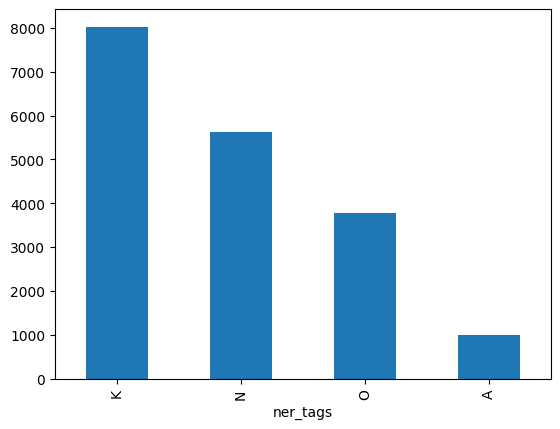

In [17]:
df["ner_tags"].value_counts().plot(kind="bar")

## SMOTE for upsamling data

Install necessary libraries

In [15]:
!pip install imblearn scikit-learn -q

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import (
    RandomOverSampler, 
    SMOTE, 
    SMOTEN,
    SMOTENC,
    ADASYN,
)

### Use tf-idf to test function only, must use tokenizer

In [17]:
tfidf = TfidfVectorizer()
X = df["tokens"].apply(str).to_numpy()
X_tfidf = tfidf.fit_transform(X)
y = df["ner_tags"].apply(str).to_numpy()
X.shape, X_tfidf.shape, y.shape

((18431,), (18431, 3764), (18431,))

In [18]:
# sm = RandomOverSampler()
sm = SMOTEN()
X_res, y_res = sm.fit_resample(X.reshape(-1, 1), y)
X_res.shape, y_res.shape

((32092, 1), (32092,))

<Axes: >

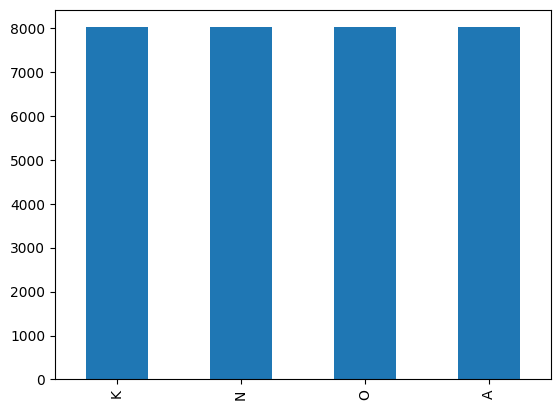

In [19]:
upsampled_df = pd.Series(y_res)
upsampled_df.value_counts().plot(kind="bar")

In [20]:
X_res_sample = X_res[0]
X_res_sample

array(['cat toc'], dtype=object)

In [21]:
balanced_df = pd.DataFrame({"phrase_tokens": X_res.reshape(-1), "phrase_ner_tags": y_res})
balanced_df.sample(10)

,phrase_tokens,phrase_ner_tags
15603,oc lau nuong,K
24237,172,A
5271,toc nam,K
5330,hair salon,K
4849,xuan,N
8997,hello,N
2479,luxury,O
10848,co hue,N
3257,pham noi that,K
16840,han,O


### Convert balanced df into IOB2 format

In [22]:
balanced_df["tokens"] = balanced_df["phrase_tokens"].apply(lambda x: x.split(" "))
balanced_df["tokens"].sample(10)

16764                                  [coffee]
8704                            [139/36a, dinh]
16323                               [com, chay]
25297                                     [163]
20066                                     [163]
8077                                     [sang]
29345    [25k, co, hop, mang, dt, 0899.785.588]
12439                                  [co, ha]
1913                                    [thanh]
23432                                     [163]
Name: tokens, dtype: object

In [23]:
balanced_df["ner_tags"] = None
balanced_df.head(10)

,phrase_tokens,phrase_ner_tags,tokens,ner_tags
0,cat toc,K,"[cat, toc]",None
1,duy hung,N,"[duy, hung]",None
2,buffalo,N,[buffalo],None
3,barbershop,K,[barbershop],None
4,0335 403 698,O,"[0335, 403, 698]",None
5,buffalo,N,[buffalo],None
6,barbershop,K,[barbershop],None
7,0335 403 698,O,"[0335, 403, 698]",None
8,hot toc,K,"[hot, toc]",None
9,dt 0766.642.957,O,"[dt, 0766.642.957]",None


In [24]:
for i, row in balanced_df.iterrows():
    ner_tags = balanced_df.loc[i, "phrase_ner_tags"]
    tokens = balanced_df.loc[i, "tokens"]
    if ner_tags == "O":
        ner_tags = [ner_tags] * len(tokens)
    else:
        ner_tags = [f"B-{ner_tags}"] + [f"I-{ner_tags}"] * (len(tokens) - 1)

    # print(ner_tags)
    balanced_df.loc[i, "ner_tags"] = " ".join(ner_tags)

In [25]:
balanced_df["ner_tags"] = balanced_df["ner_tags"].apply(lambda x: x.split(" "))
balanced_df.head(10)

,phrase_tokens,phrase_ner_tags,tokens,ner_tags
0,cat toc,K,"[cat, toc]","[B-K, I-K]"
1,duy hung,N,"[duy, hung]","[B-N, I-N]"
2,buffalo,N,[buffalo],[B-N]
3,barbershop,K,[barbershop],[B-K]
4,0335 403 698,O,"[0335, 403, 698]","[O, O, O]"
5,buffalo,N,[buffalo],[B-N]
6,barbershop,K,[barbershop],[B-K]
7,0335 403 698,O,"[0335, 403, 698]","[O, O, O]"
8,hot toc,K,"[hot, toc]","[B-K, I-K]"
9,dt 0766.642.957,O,"[dt, 0766.642.957]","[O, O]"


In [26]:
balanced_df = balanced_df[["tokens", "ner_tags"]]
balanced_df.sample(10)

,tokens,ner_tags
21648,[163],[B-A]
3051,"[phone, 0919, 637, 169]","[O, O, O, O]"
25783,[57],[B-N]
1086,"[john, huynh]","[B-N, I-N]"
25902,[phuc],[B-N]
25994,[57],[B-N]
29670,"[25k, co, hop, mang, dt, 0899.785.588]","[O, O, O, O, O, O]"
25563,[57],[B-N]
22618,[163],[B-A]
5016,[hair],[B-K]


In [27]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tokens    32092 non-null  object
 1   ner_tags  32092 non-null  object
dtypes: object(2)
memory usage: 501.6+ KB


<Axes: xlabel='tokens'>

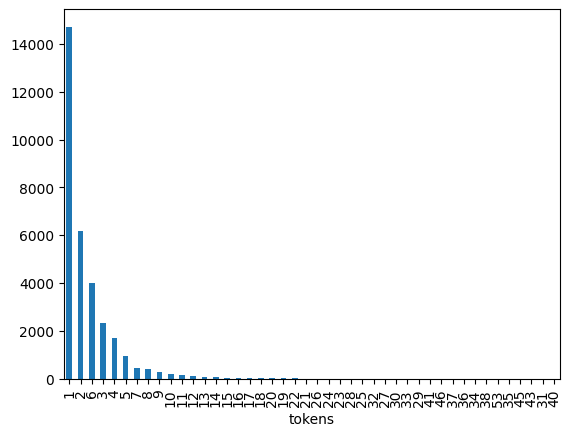

In [28]:
balanced_df["tokens"].apply(len).value_counts().plot(kind="bar")

## Convert to Dataset

In [27]:
train_cleaned_data = clean_data(train_raw_data, label2id=None, scheme="io")
train_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7078 entries, 0 to 7077
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tokens    7078 non-null   object
 1   ner_tags  7078 non-null   object
dtypes: object(2)
memory usage: 110.7+ KB


In [8]:
train_cleaned_data.sample(10)

,tokens,ner_tags
6219,"[plus, tp, sa, dec, dong, thap, hotline, 084, ...","[N, A, A, A, A, A, O, O, O, O]"
2710,"[cat, toc, su, trang, cat, va, tao, mau, toc, ...","[K, K, N, N, K, K, K, K, K, K, K, K, K, K, K, K]"
3908,"[quan, hong, ha, noi, bun, rieu, oc, ca, dc, 2...","[K, N, N, N, K, K, K, K, A, A, A, A, A, A, A, ..."
686,"[cat, toc, kieu, trang]","[K, K, N, N]"
6119,"[quan, ngoc, com, com, gia, dinh, 2, thu, kho,...","[N, N, K, K, K, K, K, K, K, K, K]"
6205,"[thien, bao, ca, phe, ca, phe, da, 10k, tra, c...","[N, N, K, K, K, K, K, O, K, K, K, K, O, K, K, ..."
1374,"[hair, salon, hoang, 65, cat, toc, nam, nu, ta...","[K, K, N, A, K, K, K, K, K, K, K, K, K, O, O, ..."
1572,"[beauty, skincare]","[K, K]"
4401,"[ba, mo, hieu, dac, san, bun, chia, dc, 92, le...","[N, N, K, K, K, K, K, A, A, A, A, A, A, A, A, A]"
87,"[phuong, nail]","[N, N]"


In [28]:
# _dataset = get_conll_dataset(balanced_df, labels=LABELS)
from dataset import get_labels

_dataset = get_conll_dataset(train_cleaned_data, labels=get_labels("io"))
_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 7078
})

<Axes: >

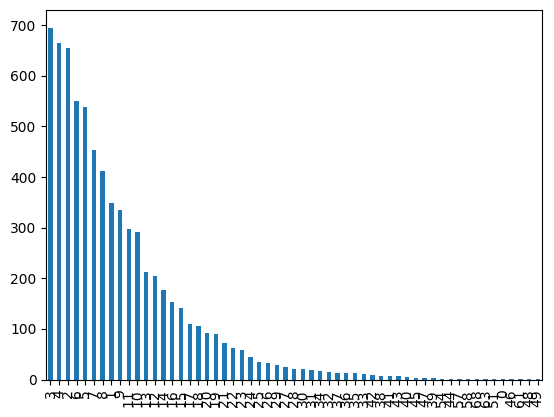

In [29]:
labels = pd.Series(_dataset["ner_tags"]).apply(len)
labels.value_counts().plot(kind="bar")

## Augment, balance, ...

In [12]:
from augment import EntityBalancer

balancer = EntityBalancer(_dataset)
balanced_dataset = balancer.balance()
print(balanced_dataset)

Map:   0%|          | 0/7078 [00:00<?, ? examples/s]

Map: 100%|██████████| 7078/7078 [01:06<00:00, 106.92 examples/s]

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 7078
})


In [13]:
from augment import augment
augment_datasets = [augment(_dataset, keep_original=x) for x in [True, False]]

Filter: 100%|██████████| 28252/28252 [00:01<00:00, 25952.92 examples/s]


In [14]:
augment_datasets[0]["ner_tags"]

[[1, 2],
 [3, 4],
 [3, 1, 0, 0, 0],
 [1, 2, 0, 0, 3, 4],
 [3, 4, 0, 0, 0, 0, 0, 0],
 [1, 2, 3],
 [1,
  2,
  2,
  2,
  0,
  3,
  4,
  1,
  2,
  2,
  2,
  2,
  2,
  5,
  6,
  6,
  6,
  1,
  2,
  2,
  0,
  0,
  0,
  0,
  3,
  5],
 [1, 2, 3, 4],
 [1,
  2,
  2,
  3,
  4,
  4,
  1,
  2,
  0,
  0,
  0,
  1,
  2,
  2,
  2,
  0,
  0,
  0,
  0,
  1,
  2,
  0,
  0,
  1,
  2,
  0,
  0,
  5,
  6,
  6,
  6,
  0,
  0,
  0],
 [1, 2, 2, 2, 2, 2, 2],
 [1, 2, 3],
 [1, 2, 2, 2],
 [1, 2, 2, 3, 4, 4, 4, 0, 0, 5, 6, 6, 6, 6, 6],
 [1, 3, 1, 2, 2],
 [3, 1, 3, 0, 0, 0],
 [3, 4, 1, 2],
 [3, 1, 2, 2, 2, 2, 3],
 [1, 2, 3, 4],
 [3, 1, 5, 6, 6, 0, 0, 0],
 [1, 3, 4, 1],
 [1, 2, 2, 0, 0, 0, 0],
 [3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 6, 6, 6, 0, 0, 0, 0],
 [1, 2, 2, 3, 4, 1, 2, 2, 2, 2, 2],
 [1, 2, 2],
 [1, 3, 1],
 [1, 2, 3, 4, 5, 6, 6],
 [1, 2, 0, 1, 2, 2, 2, 2, 2, 0, 0],
 [1, 2, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0],
 [1, 2, 2, 2, 3],
 [1, 2, 3, 4, 5, 6, 6, 6, 0, 0, 0],
 [3, 1, 2],
 [3, 1, 2],
 [1, 2, 3],
 [1, 0, 

In [15]:
! pip install emoji

In [16]:
from adaptive_resampling import NER_Adaptive_Resampling

def save_text_data(conlldf, filename):
    text = conlldf2text(conlldf)
    with open(filename, "w", encoding="utf-8") as f:
        f.write(text)

In [17]:
textfile = "/mnt/data/src/ner/data/Data_Ner.txt"
save_text_data(train_cleaned_data, textfile)

In [18]:
def get_resampled_dataset(textfile, typ="BUS"):
    textfile_stem = Path(textfile).stem
    textfile_dir = Path(textfile).parent
    resampled_textfile = f"{textfile_dir}/{textfile_stem}_{typ}.txt"

    ner = NER_Adaptive_Resampling(textfile, resampled_textfile)
    if typ != "BUS":
        ner.resamp(typ)
    else:
        ner.BUS()

    with open(resampled_textfile, "r") as f:
        text = f.read()
        df = conlltext2df(text)
    
    _dataset = get_conll_dataset(df, labels=LABELS)
    return _dataset

In [19]:
types = ["BUS", "sc", "sCR", "sCRD", "nsCRD"]
resampled_datasets = [get_resampled_dataset(textfile, typ=typ) for typ in types]

In [20]:
resampled_datasets[0]["ner_tags"]

[[3, 4],
 [3, 1, 0],
 [3, 1, 0],
 [1, 2, 0, 0, 3, 4],
 [3, 4, 0, 0, 0, 0],
 [1, 2, 3],
 [2, 2, 2, 0, 3, 4, 1, 2, 2, 2, 2, 2, 5, 6, 6, 6, 1, 2, 2, 0, 0, 0, 0, 3, 5],
 [1, 2, 3, 4],
 [1, 2, 2, 3, 4, 4, 1, 2, 0, 0, 1, 2, 0, 0, 5, 6, 6, 6, 0, 0, 0],
 [1, 2, 3],
 [1, 2, 2, 3, 4, 4, 4, 0, 0, 5, 6, 6, 6, 6, 6],
 [1, 3, 1],
 [3, 1, 3, 0, 0, 0],
 [3, 4, 1, 2],
 [3, 1, 2, 2, 2, 3],
 [1, 2, 3, 4],
 [3, 1, 5, 6, 6, 0, 0, 0],
 [1, 3, 4, 1],
 [3, 1, 2, 2, 2, 2, 2, 2, 2, 5, 6, 6, 6, 6, 0, 0, 0, 0],
 [2, 2, 3, 4, 1, 2],
 [1, 3, 1],
 [1, 2, 3, 4, 5, 6, 6],
 [2, 2, 3, 4, 0, 0],
 [2, 2, 3],
 [1, 2, 3, 4, 5, 6, 6, 6, 0, 0, 0],
 [3, 1, 2],
 [3, 1, 2],
 [1, 2, 3],
 [0, 0, 3, 4, 1, 2],
 [3],
 [3, 4, 1, 2, 5, 1],
 [3, 4, 4, 4, 0, 0],
 [1, 2, 3, 4, 0, 1],
 [1, 2, 3, 4, 1, 2, 0, 0, 5, 0],
 [1, 2, 3],
 [3],
 [1, 3, 4, 1, 2, 2],
 [3, 1, 2, 2, 2, 0, 0, 5, 6],
 [3, 1],
 [2, 2, 3, 4, 1, 2],
 [2, 0, 3],
 [2, 2, 3, 4, 1, 2],
 [3, 1, 2],
 [1, 2, 2, 3, 4, 4, 5, 6, 6, 0, 0],
 [2, 2, 3, 4, 1, 2],
 [3, 1, 2],
 [2, 2, 3, 4,

## Distribution of the number of tokens 

In [21]:
df = _dataset.to_pandas()
df.head()

,tokens,ner_tags
0,"[CAT, TOC]","[1, 2]"
1,"[DUY, HUNG]","[3, 4]"
2,"[BUFFALO, BARBERSHOP, 0335, 403, 698]","[3, 1, 0, 0, 0]"
3,"[BUFFALO, BARBERSHOP, 0335, 403, 698]","[3, 1, 0, 0, 0]"
4,"[HOT, TOC, DT, 0766.642.957, DUY, PHUONG]","[1, 2, 0, 0, 3, 4]"


In [22]:
from collections import Counter

# The returned dict has the key as the number of tokens and the value as the number of occurrences
counts = Counter(df.tokens.apply(lambda x: len(x)))

print("Most common number of tokens: ", counts.most_common(5))
print("Max number of tokens: ", max(counts))

Most common number of tokens:  [(3, 695), (4, 664), (2, 654), (6, 550), (5, 538)]
Max number of tokens:  68


In [23]:
def plot_bar_chart(x, height, title="", figsize=None):
    plt.figure(figsize=figsize, layout="constrained")
    plt.bar(x, height)
    plt.title(title)
    plt.xlabel("Number of tokens")
    plt.ylabel("Number of occurrences")
    plt.show()

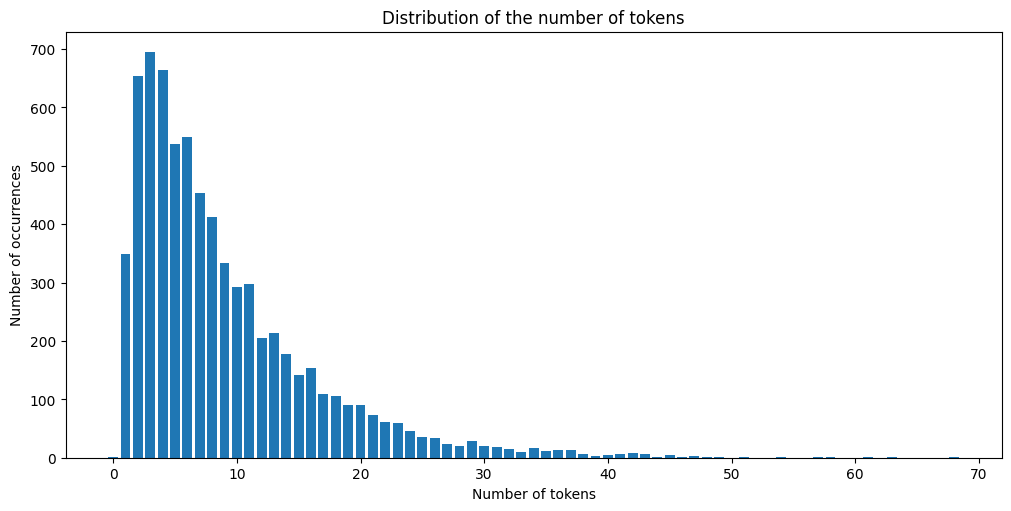

In [24]:
plot_bar_chart(
    x=list(counts.keys()),
    height=list(counts.values()),
    title="Distribution of the number of tokens",
    figsize=(10, 5),
)

## Ratios of labels in different datasets

In [31]:
def get_plot_data(_datasets: list[Dataset], id2label: dict = ID2LABEL):
    data = []

    for dataset in _datasets:
        ner_tags = [id2label.get(item) for sublist in dataset["ner_tags"] for item in sublist]
        values, counts = np.unique(ner_tags, return_counts=True)
        index_array = np.argsort(values)
        data.append({
            "count": counts[index_array],
            "labels": values[index_array],
        })

    return data

In [32]:
def plot_pie_charts(data,titles=None, suptitle="", figsize=(10, 10)):
    plt.figure(figsize=figsize, layout="constrained")
    ncols = 4
    nrows = (len(data) // ncols) + int(len(data) % ncols > 0)

    for i, _data in enumerate(data):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.pie(_data["count"], labels=_data["labels"], autopct="%.1f%%")

        if titles:
            ax.set_title(titles[i])
                 
    if suptitle:
        plt.suptitle(suptitle)
    plt.show()

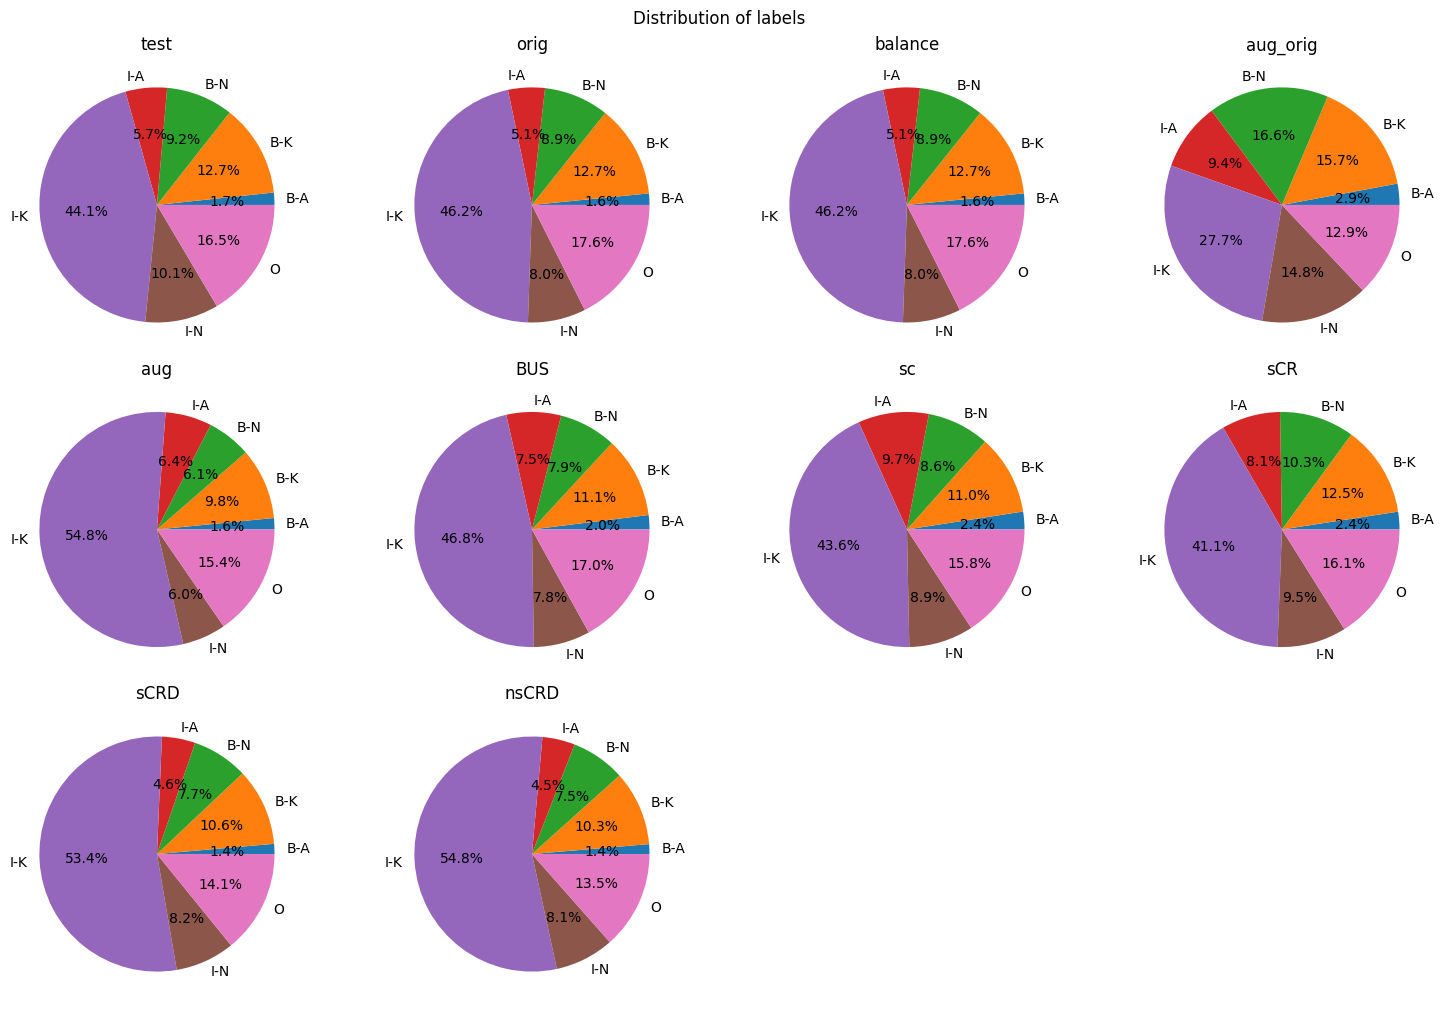

In [33]:
_datasets = [test_dataset, _dataset, balanced_dataset] + resampled_datasets + augment_datasets
titles = ["test","orig", "balance", "aug_orig", "aug"] + types
data = get_plot_data(_datasets)
plot_pie_charts(data, titles, suptitle="Distribution of labels", figsize=(15, 10))

## Tokenizer

In [18]:
from dataset import get_train_dataset

based_tokenizer = AutoTokenizer.from_pretrained("NlpHUST/electra-base-vn")
tokenizer = AutoTokenizer.from_pretrained("/mnt/data/src/ner/fine_tune/train_orig_aug2/model")

/mnt/data/src/ner/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
one_tag_df = df.copy()
label2id = get_label2id("io")

one_tag_df["ner_tags"] = one_tag_df["ner_tags"].apply(lambda x: [label2id.get(x, 0)]) * one_tag_df["tokens"].apply(lambda x: len(x.split(" ")))
one_tag_df["tokens"] = one_tag_df["tokens"].apply(lambda x: list(map(str, x.split(" "))))
one_tag_df.sample(10)

,tokens,ner_tags
5251,"[uon, duoi, nhuom, collagen, the, he, make, up...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
12915,"[bia, hoi, ha, noi]","[1, 1, 1, 1]"
9956,"[dt, 0914011311]","[0, 0]"
8635,"[goi, ca]","[1, 1]"
6616,"[spa, noi, mi]","[1, 1, 1]"
13876,"[kim, quynh]","[2, 2]"
16024,"[dt, 0363.736.371]","[0, 0]"
9120,"[thanh, truc]","[2, 2]"
1792,"[tao, kieu, hien, dai, co, dien, cat, say, cao...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6469,"[my, nail]","[2, 2]"


In [20]:
one_tag_df = one_tag_df.reset_index(drop=True)
one_tag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18431 entries, 0 to 18430
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tokens    18431 non-null  object
 1   ner_tags  18431 non-null  object
dtypes: object(2)
memory usage: 288.1+ KB


In [21]:
dataset2 = Dataset.from_pandas(one_tag_df)
dataset2

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 18431
})

In [23]:
from dataset import tokenize_and_align_labels

train_dataset2 = dataset2.map(
    lambda x: tokenize_and_align_labels(
        x["tokens"], x["ner_tags"], tokenizer, False
    ),
    batched=True,
    remove_columns=["tokens", "ner_tags"],
)
train_dataset2

Map: 100%|██████████| 18431/18431 [00:01<00:00, 10084.63 examples/s]


Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 18431
})

### Try different tokenizers

In [12]:
from dataset import get_train_dataset

based_train_dataset = get_train_dataset(_dataset, based_tokenizer)
train_dataset = get_train_dataset(_dataset, tokenizer)

Map:   0%|          | 0/7078 [00:00<?, ? examples/s]

Map: 100%|██████████| 7078/7078 [00:00<00:00, 8262.92 examples/s] 


In [23]:
based_train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 7078
})

In [24]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 7078
})

The below result means that tokenizers are the same, even if train or not.

In [25]:
all((
    based_train_dataset["input_ids"] == train_dataset["input_ids"], 
    based_train_dataset["token_type_ids"] == train_dataset["token_type_ids"], 
    based_train_dataset["attention_mask"] == train_dataset["attention_mask"], 
    based_train_dataset["labels"] == train_dataset["labels"], 
))

True

### Try upsampling again

In [33]:
X = np.vstack(train_dataset2.to_pandas().apply(np.hstack, axis=1))
y = df['ner_tags'].values
X.shape, y.shape

((18431, 512), (18431,))

In [34]:
from imblearn.over_sampling import ADASYN

ads = ADASYN()
X_resampled, y_resampled = ads.fit_resample(X, y)
X_resampled.shape, y_resampled.shape

((32189, 512), (32189,))

<Axes: >

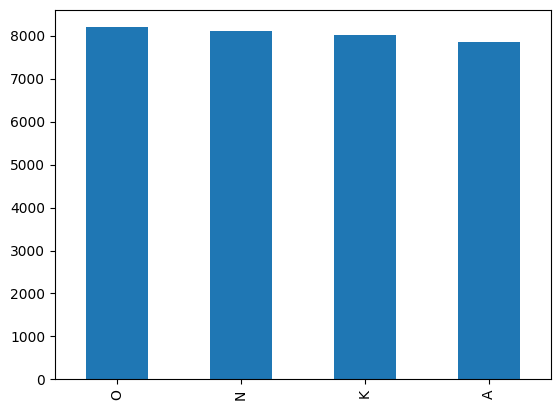

In [36]:
pd.Series(y_resampled).value_counts().plot(kind="bar")

In [35]:
resampled_df = pd.DataFrame({
    'input_ids': list(X_resampled[:, :128]),
    'token_type_ids': list(X_resampled[:, 128:256]),
    'attention_mask': list(X_resampled[:, 256:384]),
    'labels': list(X_resampled[:, 384:]), 
})

resampled_dataset = Dataset.from_pandas(resampled_df)
resampled_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 32189
})

### Analyse the tokenized dataset

In [36]:
first_sample = train_dataset[0]
len(first_sample["input_ids"]), len(first_sample["labels"]), len(first_sample["token_type_ids"]), len(first_sample["attention_mask"])

(128, 128, 128, 128)

In [39]:
np.array(train_dataset["input_ids"]).dtype, np.array(train_dataset["labels"]).shape

(dtype('int64'), (7078, 128))

In [41]:
np.array(train_dataset["input_ids"])[-5:, -5:]

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

<Axes: >

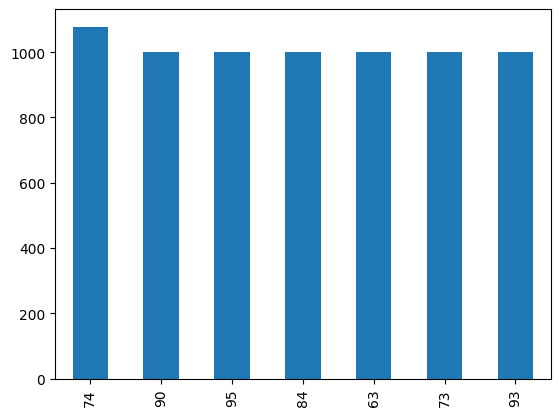

In [31]:
labels = pd.Series(train_dataset["labels"]).apply(len)
labels.value_counts().plot(kind="bar")

In [26]:
sample_input_ids = np.array(train_dataset["input_ids"][0])
sample_input_ids[sample_input_ids > 0]

array([  2, 706, 444, 968, 472,   3])

In [ ]:
tokenized_input = tokenizer([example_text], is_split_into_words=True)
tokenized_input.keys()

In [ ]:
tokenized_input["input_ids"]

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"][0])
tokens

In [ ]:
word_ids = tokenized_input.word_ids()
word_ids

### Tokenize and align labels

The below function does 2 jobs

1. set -100 as the label for special tokens
2. mask the subword representations after the first subword

In [11]:
def tokenize_and_align_labels(data, label_all_tokens=True):
    words = [x["words"] for x in data]
    tags = [[tags_to_ids[tag] for tag in x["tags"]] for x in data]
    tokenized_input = tokenizer(words, truncation=True, is_split_into_words=True)
    labels = []

    for i, label in enumerate(tags):
        word_ids = tokenized_input.word_ids(batch_index=i)
        previous_word_id = None
        
        label_ids = []

        for word_id in word_ids:
            if word_id is None:
                # set -100 b/c these special characters 
                # are ignored by pytorch when training
                label_ids.append(-100) 
            elif word_id != previous_word_id:
                # if current word_id != prev when it's the most regular case
                # and add the corresponding token
                label_ids.append(label[word_id])
            else:
                # for sub-word which has the same word_id
                # set -100 as well only if label_all_tokens=False
                if not label_all_tokens:
                    label_ids.append(label[word_id])
                else:
                    label_ids.append(-100)

            previous_word_id = word_id 
        
        labels.append(label_ids)
    
    tokenized_input["labels"] = labels
    return tokenized_input


In [ ]:
tokenized_input = tokenize_and_align_labels([example_data])
tokenized_input.keys()

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"][0])

for token, label in zip(tokens, tokenized_input["labels"][0]):
    print(f"{token:_<40} {label}")

In [ ]:
tokenized_train_data = tokenize_and_align_labels(train_data)
type(tokenized_train_data)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("NlpHUST/electra-base-vn", num_labels=21)

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    "../test-fine-tune-ner",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=1,
    weight_decay=0.01,
)

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")

In [23]:
def compute_metrics(eval_preds, label_list=tags, metric=metric):
    pred_logits, labels = eval_preds
    pred_logits = np.argmax(pred_logits, axis=2)

    predictions = [
        [
            label_list[eval_preds] for prediction, label in zip(pred_logits, labels) for (eval_preds, l) in zip(prediction, label) if l != -100
        ]
    ]

    true_labels = [
        [
            label_list[l] for prediction, label in zip(pred_logits, labels) for (eval_preds, l) in zip(prediction, label) if l != -100
        ]
    ]

    results = metric.compute(predictions=predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],        
    }

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_dict(tokenized_train_data.data)
# train_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
train_dataset

In [ ]:
for i in train_dataset.iter(1):
    print(i)
    break

In [26]:
for param in model.parameters():
    param.data = param.data.contiguous()

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
model.save_pretrained("test-fine-tune-model")
tokenizer.save_pretrained("test-fine-tune-tokenizer")

In [ ]:
id2label = {str(key): value for key, value in ids_to_tags.items()}
id2label

In [ ]:
label2id = {value: key for key, value in id2label.items()}
label2id

In [33]:
import json

config_path = "../test-fine-tune-model/config.json"

with open(config_path, "r") as f:
    config = json.load(f)

config["id2label"] = id2label
config["label2id"] = label2id

In [34]:
with open(config_path, "w") as f:
    json.dump(config, f)

## Inference

In [21]:
import sys
sys.path.append("../")
from fine_tune.inference_phoNER import *

In [22]:
model_fine_tuned = AutoModelForTokenClassification.from_pretrained("/mnt/data/src/ner/fine_tune/train_phoNER2/model3")
tokenizer = AutoTokenizer.from_pretrained("/mnt/data/src/ner/fine_tune/train_phoNER2/model3")
nlp = pipeline(
    "ner", 
    model=model_fine_tuned, 
    tokenizer=tokenizer, 
    aggregation_strategy="simple", 
    device=0,
)

In [23]:
test_data = extract_data("../data/phoNER_COVID19/test_syllable.json")
test_example = " ".join(random.choice(test_data)["words"])
test_example

'Tối 10/8 , Ban chỉ đạo phòng chống dịch Covid - 19 thành phố Đà Nẵng cho biết , hai nữ điều dưỡng vừa được Bộ Y tế công bố chiều nay là " bệnh nhân 844 " và " bệnh nhân 845 " , cùng làm việc tại Khoa Nội thận - Nội tiết ( Bệnh viện Đà Nẵng ) .'

In [24]:
result = nlp(test_example)
result

[{'entity_group': 'DATE',
  'score': 0.9847006,
  'word': '10 / 8',
  'start': 4,
  'end': 8},
 {'entity_group': 'ORGANIZATION',
  'score': 0.9840993,
  'word': 'Ban chỉ đạo phòng chống dịch Covid - 19 thành phố Đà Nẵng',
  'start': 11,
  'end': 68},
 {'entity_group': 'GENDER',
  'score': 0.89232415,
  'word': 'nữ',
  'start': 84,
  'end': 86},
 {'entity_group': 'JOB',
  'score': 0.7233406,
  'word': 'điều dưỡng',
  'start': 87,
  'end': 97},
 {'entity_group': 'ORGANIZATION',
  'score': 0.979691,
  'word': 'Bộ Y tế',
  'start': 107,
  'end': 114},
 {'entity_group': 'PATIENT_ID',
  'score': 0.9833907,
  'word': '844',
  'start': 148,
  'end': 151},
 {'entity_group': 'PATIENT_ID',
  'score': 0.9836785,
  'word': '845',
  'start': 169,
  'end': 172},
 {'entity_group': 'LOCATION',
  'score': 0.9813541,
  'word': 'Khoa Nội thận - Nội tiết ( Bệnh viện Đà Nẵng',
  'start': 195,
  'end': 239}]

In [25]:
display(test_example, result, ents, colors)

In [1]:
import sys
sys.path.append("../")
from fine_tune.inference import *

/mnt/data/src/ner/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/data/src/ner/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/mnt/data/src/ner/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
save_model = "/mnt/data/src/ner/fine_tune/train4/model"
model_fine_tuned = AutoModelForTokenClassification.from_pretrained(save_model)
tokenizer = AutoTokenizer.from_pretrained(save_model)
nlp = pipeline(
    "ner", 
    model=model_fine_tuned, 
    tokenizer=tokenizer, 
    aggregation_strategy="simple", 
    device=0
)

In [11]:
import numpy as np
from process import process_text_string

test_data = read_df("/mnt/data/src/ner/data/POI/Data_Ner_Test.xlsx")
test_examples = np.random.choice(test_data["title"].tolist(), 5).tolist()
processed_examples = [process_text_string(res) for res in test_examples]
results = [nlp(example) for example in processed_examples]
print(results)

[[{'entity_group': 'N', 'score': np.float32(0.8824244), 'word': 'Hoang Thuy', 'start': 0, 'end': 10}], [{'entity_group': 'K', 'score': np.float32(0.87611437), 'word': 'Nail Beauty Bao Ngan Nail Noi Mi Spa Cham', 'start': 0, 'end': 41}], [{'entity_group': 'N', 'score': np.float32(0.74041283), 'word': 'Nhi Beauty', 'start': 0, 'end': 10}, {'entity_group': 'K', 'score': np.float32(0.8458473), 'word': 'DC TIEN DAT', 'start': 11, 'end': 22}], [{'entity_group': 'N', 'score': np.float32(0.7980766), 'word': 'My Pham Lam Anh', 'start': 0, 'end': 15}, {'entity_group': 'K', 'score': np.float32(0.9424228), 'word': 'CUNG HM STORE SLL SI', 'start': 16, 'end': 36}, {'entity_group': 'A', 'score': np.float32(0.6462487), 'word': ', CN, DL, TDL', 'start': 36, 'end': 46}], [{'entity_group': 'K', 'score': np.float32(0.8413364), 'word': 'Tra Trai Cay', 'start': 0, 'end': 12}]]


In [12]:
import warnings
warnings.filterwarnings("ignore")

for test_example, result in zip(processed_examples, results):
    display(test_example, result, ent_maps, colors)

## Evaluation

In [2]:
import json

json_file = "/mnt/data/src/ner/fine_tune/train_original2/results.json"

with open(json_file, "r") as f:
    results = json.load(f)

results

{'A': {'precision': 0.989010989010989,
  'recall': 0.996309963099631,
  'f1': 0.9926470588235294,
  'number': 271},
 'K': {'precision': 0.9829351535836177,
  'recall': 0.9892051030421982,
  'f1': 0.9860601614086574,
  'number': 2038},
 'N': {'precision': 0.9850238257317904,
  'recall': 0.9777027027027027,
  'f1': 0.9813496100373008,
  'number': 1480},
 'overall_precision': 0.9841813867650936,
 'overall_recall': 0.9852203747690683,
 'overall_f1': 0.9847006067000791,
 'overall_accuracy': 0.9908388383397732,
 'total_time_in_seconds': 17.666311567183584,
 'samples_per_second': 107.03988734766037,
 'latency_in_seconds': 0.009342311775348272}

In [12]:
def filter_dict_by_keys(dict_: dict, key: list) -> dict:
    return {k: v for k, v in dict_.items() if k in key}

def get_metric_data(metric_results: dict, ent_maps: dict) -> dict:
    keys = ["precision", "recall", "f1"]
    metric_data = {ent_maps.get(key, key).lower(): filter_dict_by_keys(value, keys) for key, value in metric_results.items() if isinstance(value, dict)}
    metric_data["overall"] = {}

    for k, v in metric_results.items():
        if k.startswith("overall"):
            k_, k2 = k.split("_")
            if k2 in keys:
                metric_data[k_][k2] = v
    
    return metric_data

In [13]:
import sys
sys.path.append("../")

from dataset import ent_maps

metric_data = get_metric_data(results, ent_maps)

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(metric_data)
df

,address,keyword,name,overall
precision,0.989011,0.982935,0.985024,0.984181
recall,0.996310,0.989205,0.977703,0.985220
f1,0.992647,0.986060,0.981350,0.984701


In [35]:
def float2percent(num: float) -> str:
    return str(round(num*100, 2)) + "%"

In [54]:
percent_df = df.map(lambda x: x*100)
percent_df

,address,keyword,name,overall
precision,98.901099,98.293515,98.502383,98.418139
recall,99.630996,98.920510,97.770270,98.522037
f1,99.264706,98.606016,98.134961,98.470061


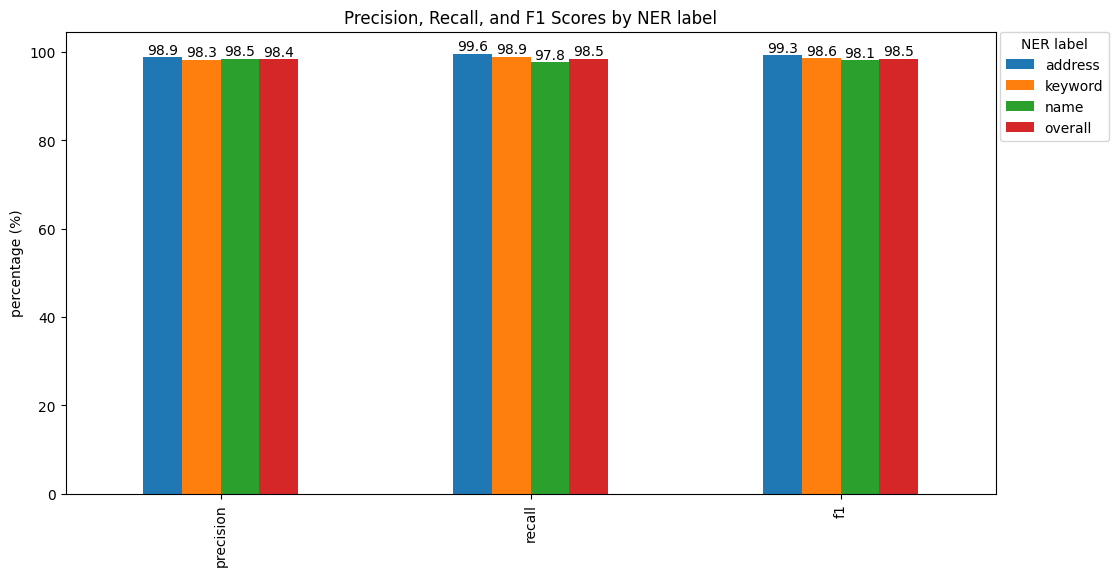

In [69]:
ax = percent_df.plot(
    kind="bar", 
    figsize=(12, 6), 
    ylabel="percentage (%)", 
    title="Precision, Recall, and F1 Scores by NER label")
ax.legend(title="NER label", bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0.)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f')

plt.show()

## Read results from csv

In [5]:
import pandas as pd 

def read_results(file_paths: list) -> pd.DataFrame:
    dfs = [pd.read_csv(file_path) for file_path in file_paths]
    return pd.concat(dfs, axis=0, ignore_index=True)

In [6]:
train_results = [
    "/mnt/data/src/ner/fine_tune/train_original2/train_results.csv",
    # "/mnt/data/src/ner/fine_tune/train_original7/train_results.csv",
]

df = read_results(train_results)
df

,train_id,train_set_volume,val_set_volume,total_volume,precision,recall,f1,accuracy,train_time,gpu_usage
0,train_original2,15743,2859,18602,0.9247,0.9407,0.9326,0.9681,10 hours,13.7 GiB


In [6]:
test_results = [
    # "/mnt/data/src/ner/fine_tune/train_original2/test_results.csv",
    # "/mnt/data/src/ner/fine_tune/train_original8/test_results.csv",
    # "/mnt/data/src/ner/fine_tune/train_orig_aug3/test_results.csv",
    "/mnt/data/src/ner/models/test_results.csv",
]

df = read_results(test_results)
df

,train_id,test_set_volume,precision,recall,f1,accuracy,date
0,model_1410,7155,0.357997,0.391516,0.374007,0.724217,13/12/2024
1,model_2110,7155,0.380155,0.390999,0.385501,0.726028,13/12/2024
2,model_3010,7155,0.615353,0.654597,0.634368,0.833635,13/12/2024
3,model_2511,7155,0.798853,0.813257,0.805991,0.922481,13/12/2024
